# First version of nucleusj in python

TODO:
- open data and metadata (with bioformat? OMERO?)
- visualise it
- auto-crop: 
    - Ostu threshold 
    - Connected component (MorpholibJ)
    - Component of volume > 1um are conserved
    - A bounding box around each connected component --> plus a 20 voxel surrounding
    - Group bounding boxes if they have a IoU > 0.5
    - Generate a Z-projection with the bouding boxes
    - A tabulated file with the list of each nucleus + bboxes coord in a .txt file
- segmentation:
    - do a thresholding Otsu then the modified Ostu?
    - gift-wrapping 
- surface area computation:
    - discrete geometry technique
    - NAMM: can we use ML to find the right transformation from the sphere images?

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
from skimage import io
import tifffile as tif
import SimpleITK as sitk
import pandas
import os
import tqdm
from PIL import Image

from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops

In [2]:
# paths
img_path = '../data/wide_field.tif'
out_path = '../data/output/'

In [67]:
# open a single image
img = io.imread(img_path)

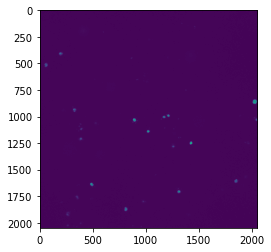

In [4]:
half = len(img)//2
plt.imshow(img[half])

## auto-crop
- Ostu threshold 
- Connected component (MorpholibJ)
- Component of volume > 1um are conserved
- A bounding box around each connected component --> plus a 20 voxel surrounding
- Group bounding boxes if they have a IoU > 0.5
- Generate a Z-projection with the bouding boxes
- A tabulated file with the list of each nucleus + bboxes coord in a .txt file

In [5]:
# ostu threshold
thresh = threshold_otsu(img)
binary = img > thresh

# print("ostu threshold: {}".format(thresh))
# plt.imshow(binary[half])

In [6]:
# connected components
connec = label(binary)
nb_connec = len(np.unique(connec))
print("number of connected components: {}".format(nb_connec))

# plt.imshow(connec[half])

number of connected components: 105


In [7]:
# volume of a connected component
def connec_volume(connec, idx):
    """
    returns the volume in pixel of the connected component of index 'idx' form the image called 'connec'
    """
    return np.sum(connec == idx)

# print the volume of all the connected components in pixel
def connec_volume_all(connec):
    nb_connec = len(np.unique(connec))
    l_connec = []
    for idx, elm in enumerate(np.unique(connec)[1:]): # remove the bg
        l_connec += [connec_volume(connec, elm)]
    return l_connec
l_connec = connec_volume_all(connec)
print(l_connec) # list of all connected component volumes (except of the bg)

[8565, 6242, 8778, 8390, 8166, 21, 5692, 6492, 6646, 7256, 6631, 6167, 24884, 1, 8362, 5479, 7736, 1, 6664, 1, 13, 1, 6049, 5797, 8291, 14, 20, 6727, 6959, 1, 1, 1, 1, 4740, 4291, 1, 6906, 1, 6203, 4243, 1, 2999, 1, 36, 3482, 1, 4, 1, 113, 4366, 2, 1, 3738, 3360, 18351, 6, 1, 1, 1, 2, 2, 1, 1, 1, 4156, 1, 3566, 4408, 1, 1, 2, 1, 1, 1, 2976, 12683, 5696, 1, 1, 57, 1, 1, 1, 2, 4261, 3, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1]


In [8]:
# remove connected component that are too small
# criteria (arbitrari): below 1000 pixel are removed

connec_clean = np.zeros_like(connec)
for idx, elm in enumerate(l_connec):
    if elm > 1000:
        connec_clean += (connec==(idx+1)).astype(int)*(idx+1)

# l_connec_clean = connec_volume_all(connec_clean)
# print(l_connec_clean)

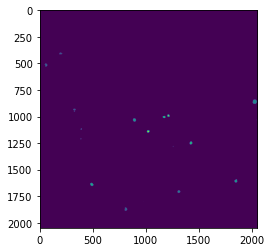

In [9]:
plt.imshow(connec_clean[half])

In [10]:
2**16

65536

In [11]:
2**np.ceil(np.log2(np.ceil(np.log2(np.max(img)))))

16.0

In [12]:
np.log2(np.ceil(np.log2(np.max(img))))

3.9068906

In [113]:
# io.use_plugin('freeimage')
# crop each connected components by a frame of 20 pixel and save them as tif files
props = regionprops(connec_clean) 

def crop_bbox(img, bbox, margin=20):
    """
    bbox: (ax,ay,az,bx,by,bz)
    """
    # adds margin and assert it is in the right range
    bbox_a = np.array(bbox)[:3]-margin
    bbox_b = np.array(bbox)[3:]+margin
    bbox_ = np.append(bbox_a, bbox_b)
    im_shape = img.shape

    for i in range(2):
        for j in range(3):
            if bbox_[i*3+j] >= img.shape[j]:
                bbox_[i*3+j] = img.shape[j] - 1
            elif bbox_[i*3+j] < 0:
                bbox_[i*3+j] = 0
    ax,ay,az,bx,by,bz = np.array(bbox_)
    return img[ax:bx,ay:by,az:bz], np.array(bbox_)


img_bits = int(2**(2**np.ceil(np.log2(np.ceil(np.log2(np.max(img)))))))


def link_metadata(array, im, out_path):
    """
    link the metadata contained in 'im' (a PIL.Image) to the numpy.array 'array' and save it in 'out_path'
    """
    # convert array to image
    frames = []
    for i, frame in enumerate(ImageSequence.Iterator(im)):
#         frame = Image.fromarray(array[i])
        print({TAGS[key] : frame.tag[key] for key in frame.tag.iterkeys()})
        
#         frame.tag['ImageWidth'] = array.shape[1]
#         frame.tag['ImageLength'] = array.shape[2]
        
        
        frames.append(frame)
        
        
    
    del im.tag[286]
    frames[0].save(out_path, tiffinfo=im.tag, save_all=True, append_images=frames[1:])


i = 0
connec_crop, bbox = crop_bbox(connec_clean, props[i].bbox)
connec_crop = ((connec_crop / np.max(connec_crop)) * (img_bits-1)).astype(np.uint16)

fname = out_path + str(i) + '.tif'

im = Image.open(img_path)
# meta_dict = {TAGS[key] : im.tag[key] for key in im.tag.iterkeys()}
# print(meta_dict)
link_metadata(connec_crop, im, fname)

    
#     for i in range(len(props)):
#         connec_crop, bbox = crop_bbox(connec_clean, props[i].bbox)
#         connec_crop = ((connec_crop / np.max(connec_crop)) * (img_bits-1)).astype(np.uint16)

#         fname = out_path + str(i) + '.tif'
    
#         region = im.crop(bbox)
#         region.save(fname)
        
#     io.imsave(fname, connec_crop)
#     bioformats.write_image(fname, connec_crop, bioformats.PT_UINT16)
#     img_itk = sitk.GetImageFromArray(connec_crop)
#     img_itk.SetSpacing(np.array((0.2e-3, 0.1032e-3,0.1032e-3))[::-1])
#     sitk.WriteImage(img_itk, fname)

AttributeError: 'ImageFileDirectory_v1' object has no attribute 'iterkeys'

In [94]:
from tifffile import memmap

# memory-map the ImageJ hyperstack
ij_hyperstack = memmap(img_path)
# process the ij_hyperstack array in-place or write results to it
# e.g. zero the second channel
ij_hyperstack[:, 1] = 0
# write any changes in the array back to the file
ij_hyperstack.flush()

ValueError: image data are not memory-mappable

In [98]:
with tif.TiffFile(img_path) as tim:
#     plt.imshow(tim.asarray())
#     print(dir(tim))
#     print(tim.asarray().shape)
    ij_meta = tim.imagej_metadata
    print(ij_meta)
    for page in tim.pages:
        for tag in page.tags:
            tag_name, tag_value = tag.name, tag.value
            print(tag_name, tag_value)



None
NewSubfileType FILETYPE.PAGE
ImageWidth 2048
ImageLength 2048
BitsPerSample 16
Compression COMPRESSION.NONE
PhotometricInterpretation PHOTOMETRIC.MINISBLACK
ImageDescription <MetaData>
<prop id="Description" type="string" value="Exposure: 60 ms&#13;&#10;Binning: 1 x 1&#13;&#10;Region: 2048 x 2048, offset at (0, 0)&#13;&#10;Subtract: Off&#13;&#10;Shading: Off&#13;&#10;Digitizer: High-precision (16-bit)&#13;&#10;Bit Depth: 16&#13;&#10;Frames to Average: 1&#13;&#10;Trigger Mode: Internal&#13;&#10;Number of trigger times: 1&#13;&#10;Output Trigger 1: LOW&#13;&#10;Output Trigger Delay 1: -0 msec&#13;&#10;Output Trigger Width 1: 0.001 msec&#13;&#10;Output Trigger 2: LOW&#13;&#10;Output Trigger 2 Delay: -0 msec&#13;&#10;Output Trigger 2 Width: 1e-006 msec&#13;&#10;Output Trigger 3: LOW&#13;&#10;Output Trigger 3 Delay: -0 msec&#13;&#10;Output Trigger 3 Width: 1e-006 msec&#13;&#10;Electron Count Conversion Factor: 0.49&#13;&#10;Electron Count Conversion Offset: 100&#13;&#10;&#13;&#10;"/>
<

NewSubfileType FILETYPE.PAGE
ImageWidth 2048
ImageLength 2048
BitsPerSample 16
Compression COMPRESSION.NONE
PhotometricInterpretation PHOTOMETRIC.MINISBLACK
ImageDescription <MetaData>
<prop id="Description" type="string" value="Exposure: 60 ms&#13;&#10;Binning: 1 x 1&#13;&#10;Region: 2048 x 2048, offset at (0, 0)&#13;&#10;Subtract: Off&#13;&#10;Shading: Off&#13;&#10;Digitizer: High-precision (16-bit)&#13;&#10;Bit Depth: 16&#13;&#10;Frames to Average: 1&#13;&#10;Trigger Mode: Internal&#13;&#10;Number of trigger times: 1&#13;&#10;Output Trigger 1: LOW&#13;&#10;Output Trigger Delay 1: -0 msec&#13;&#10;Output Trigger Width 1: 0.001 msec&#13;&#10;Output Trigger 2: LOW&#13;&#10;Output Trigger 2 Delay: -0 msec&#13;&#10;Output Trigger 2 Width: 1e-006 msec&#13;&#10;Output Trigger 3: LOW&#13;&#10;Output Trigger 3 Delay: -0 msec&#13;&#10;Output Trigger 3 Width: 1e-006 msec&#13;&#10;Electron Count Conversion Factor: 0.49&#13;&#10;Electron Count Conversion Offset: 100&#13;&#10;&#13;&#10;"/>
<prop 

In [80]:
tim

array([[[509, 425, 275, ..., 350, 365, 183],
        [338, 237, 387, ..., 246, 334, 202],
        [546, 428, 354, ..., 287, 159, 351],
        ...,
        [604, 443, 159, ..., 225, 507, 250],
        [269, 216, 135, ..., 195, 426, 280],
        [309, 183, 308, ...,  92, 398, 255]],

       [[118, 215, 251, ..., 269,  86,  91],
        [445, 149, 217, ..., 267, 200, 182],
        [198, 193, 416, ..., 537, 240, 398],
        ...,
        [292, 304, 342, ..., 123, 450, 264],
        [129, 302, 148, ..., 434, 106, 354],
        [152, 380, 272, ..., 254, 291, 263]],

       [[220, 216, 368, ..., 260, 403, 189],
        [220, 198, 347, ..., 255, 105, 129],
        [288, 216, 422, ..., 166, 208, 147],
        ...,
        [238,  97, 126, ..., 355, 144, 161],
        [402, 193,  63, ..., 122, 161, 224],
        [349, 186, 101, ..., 238, 202,  64]],

       ...,

       [[133, 160, 437, ..., 313, 406, 261],
        [180, 468, 473, ..., 198, 396, 342],
        [449, 269, 211, ..., 284, 196, 213

(2048, 2048)


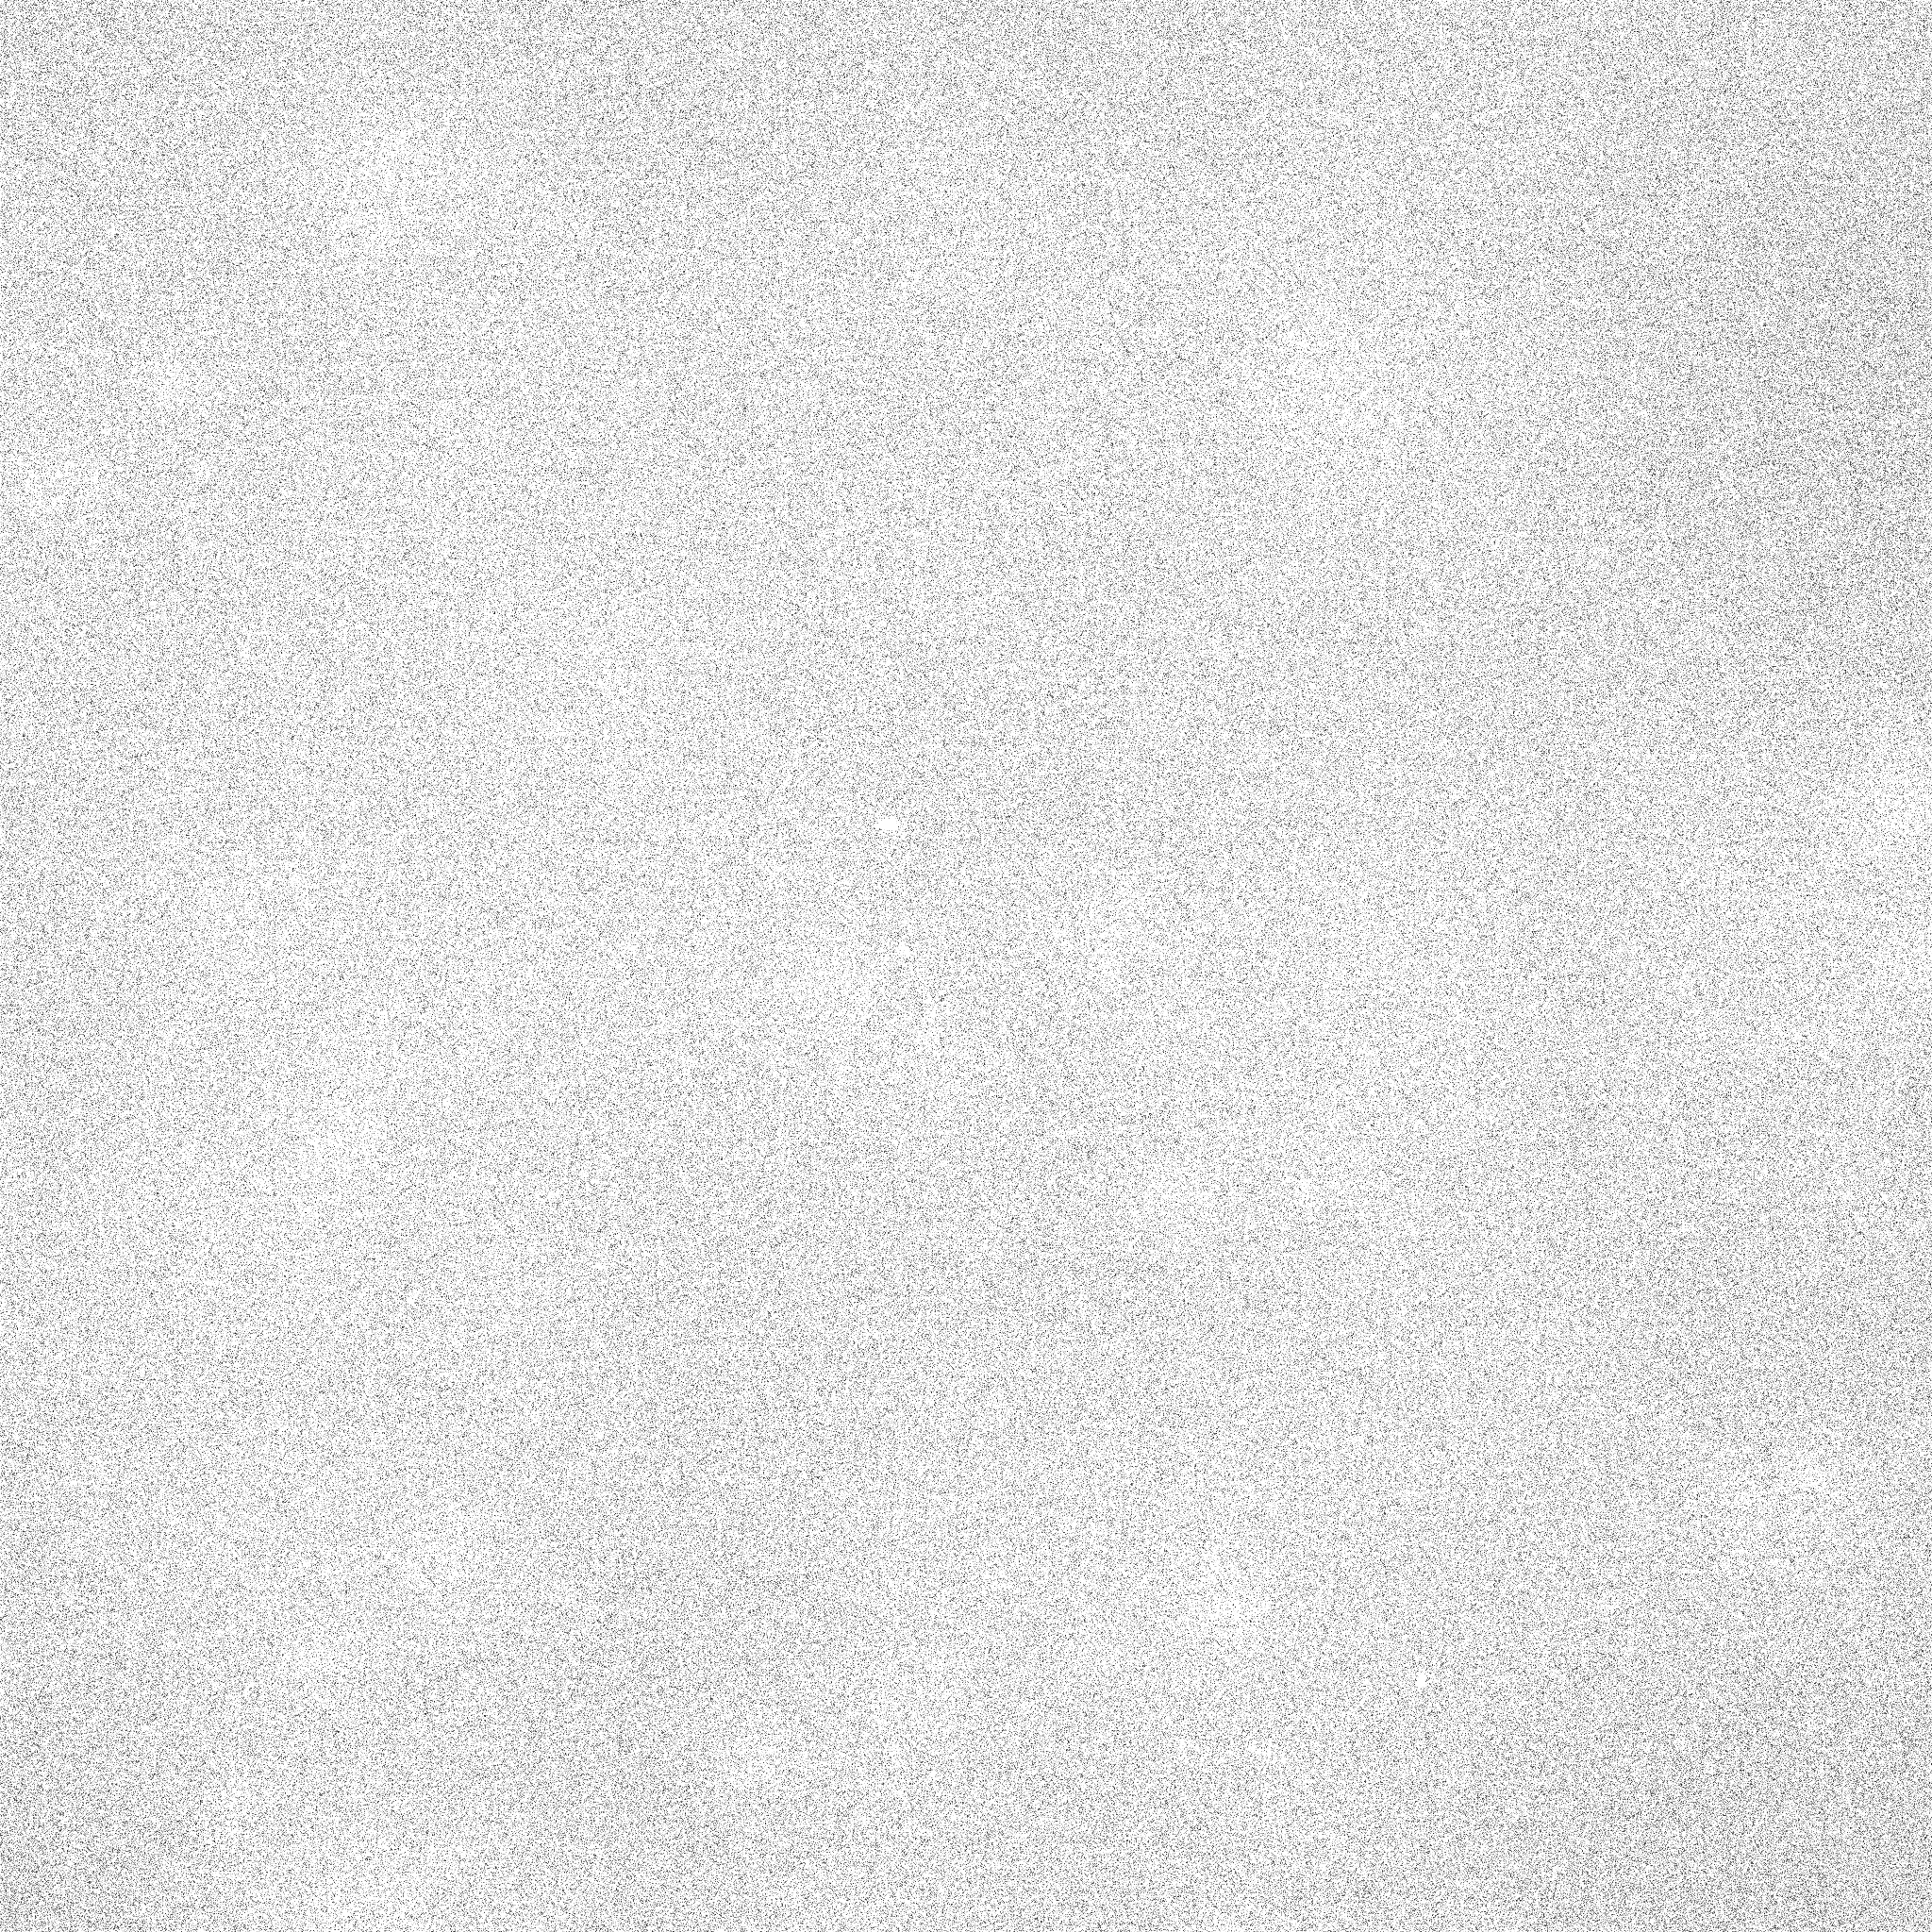

In [74]:
with Image.open(img_path) as im:
#     for k,e in im.tag.items():
#         print(k)
#         print(e)
    print(im.size)
    im.show()

In [99]:
from PIL import Image, ImageSequence
path = 'sample.tiff'

im = Image.open(path)
frames = []
for i, frame in enumerate(ImageSequence.Iterator(im)):
    frame = frame.copy()

    # Perform an operation, for example, rotate the second frame
    if i == 1:
        frame = frame.rotate(5)

    frames.append(frame)
del im.tag[286]
frames[0].save('../data/rot.tif', tiffinfo=im.tag, save_all=True, append_images=frames[1:])

In [14]:
import javabridge
import bioformats
javabridge.start_vm(class_path=bioformats.JARS)

In [43]:
t = bioformats.Image()

AttributeError: module 'bioformats' has no attribute 'Image'

In [37]:
j_im = bioformats.ImageReader(img_path)
bioformats.write_image()

14:15:26.099 [Thread-0] DEBUG loci.formats.ClassList - Could not find loci.formats.in.URLReader
java.lang.ClassNotFoundException: loci.formats.in.URLReader
	at java.net.URLClassLoader.findClass(URLClassLoader.java:382) ~[na:1.8.0_292]
	at java.lang.ClassLoader.loadClass(ClassLoader.java:418) ~[na:1.8.0_292]
	at sun.misc.Launcher$AppClassLoader.loadClass(Launcher.java:352) ~[na:1.8.0_292]
	at java.lang.ClassLoader.loadClass(ClassLoader.java:351) ~[na:1.8.0_292]
	at java.lang.Class.forName0(Native Method) ~[na:1.8.0_292]
	at java.lang.Class.forName(Class.java:264) ~[na:1.8.0_292]
	at loci.formats.ClassList.parseLine(ClassList.java:196) [bioformats_package.jar:6.6.0]
	at loci.formats.ClassList.parseFile(ClassList.java:258) [bioformats_package.jar:6.6.0]
	at loci.formats.ClassList.<init>(ClassList.java:138) [bioformats_package.jar:6.6.0]
14:15:26.100 [Thread-0] DEBUG loci.formats.ClassList - Could not find loci.formats.in.SlideBook6Reader
java.lang.ClassNotFoundException: loci.formats.in.S

AttributeError: 'ImageReader' object has no attribute '__attr__'

In [39]:
def props(cls):   
    return [i for i in cls.__dict__.keys() if i[:1] != '_']

properties = props(bioformats.ImageReader)
print(properties)

['download', 'close', 'init_reader', 'read']


In [40]:
help(j_im.download)

Help on method download in module bioformats.formatreader:

download(url) method of bioformats.formatreader.ImageReader instance



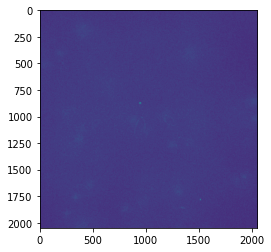

In [34]:
plt.imshow(j_im)

In [15]:
connec_clean(props[0].bbox)

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
props[0].major_axis_length

In [ ]:
help(props[0])